In [39]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from src.few_shot_learning import load_cinic10, calculate_accuracy, plot_confusion_matrix

class FewShotResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FewShotResNet, self).__init__()
        self.backbone = models.resnet18(weights="IMAGENET1K_V1")  # Load pretrained model
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)  # Replace last layer
    
    def forward(self, x):
        return self.backbone(x)

In [40]:
torch.hub.set_dir("../../models")

In [60]:
def train_few_shot(model, dataloader, epochs=10, lr=0.001):
    for param in model.backbone.parameters():
        param.requires_grad = False  # Freeze all layers

    # Unfreeze last two ResNet layers (layer4 & fc)
    for param in model.backbone.layer3.parameters():
        param.requires_grad = True
    for param in model.backbone.layer4.parameters():
        param.requires_grad = True
    for param in model.backbone.fc.parameters():
        param.requires_grad = True
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in dataloader:  # Load few-shot dataset
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

In [61]:
data_dir = "../../data"
dataloader = load_cinic10(data_dir, few_shot_per_class=100)
model = FewShotResNet()
train_few_shot(model, dataloader, epochs=30)

Epoch [1/30], Loss: 144.6891
Epoch [2/30], Loss: 104.0682
Epoch [3/30], Loss: 93.7004
Epoch [4/30], Loss: 76.3413
Epoch [5/30], Loss: 63.8454
Epoch [6/30], Loss: 53.5186
Epoch [7/30], Loss: 44.9583
Epoch [8/30], Loss: 34.3816
Epoch [9/30], Loss: 38.2869
Epoch [10/30], Loss: 31.6985
Epoch [11/30], Loss: 29.0233
Epoch [12/30], Loss: 22.1534
Epoch [13/30], Loss: 20.4771
Epoch [14/30], Loss: 19.9151
Epoch [15/30], Loss: 19.2448
Epoch [16/30], Loss: 20.2106
Epoch [17/30], Loss: 20.3303
Epoch [18/30], Loss: 14.8989
Epoch [19/30], Loss: 16.4686
Epoch [20/30], Loss: 11.9216
Epoch [21/30], Loss: 12.6582
Epoch [22/30], Loss: 13.6220
Epoch [23/30], Loss: 8.9572
Epoch [24/30], Loss: 10.9703
Epoch [25/30], Loss: 9.6792
Epoch [26/30], Loss: 10.2354
Epoch [27/30], Loss: 6.5009
Epoch [28/30], Loss: 7.3821
Epoch [29/30], Loss: 5.7753
Epoch [30/30], Loss: 6.1223


In [62]:
train_accuracy = calculate_accuracy(model, data_dir, split='train')

Accuracy on train set: 45.09%


In [63]:
test_accuracy = calculate_accuracy(model, data_dir, split='test')

Accuracy on test set: 44.77%


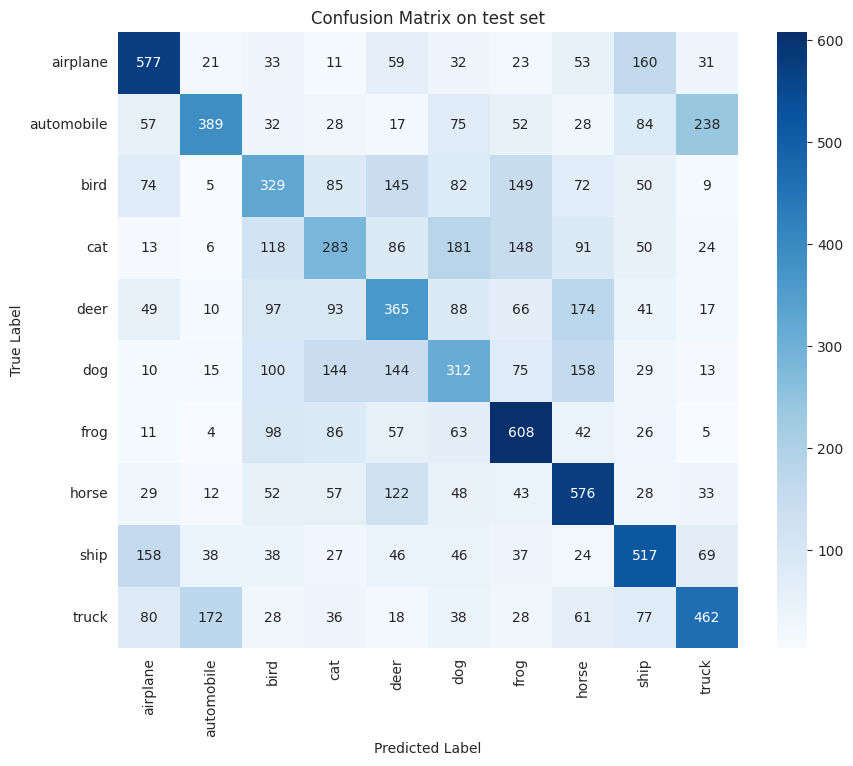

In [64]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(model, data_dir, split='test', class_names=class_names)

In [65]:
import torch.nn.functional as F
class CosineClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_classes, in_features))  # Class prototypes

    def forward(self, x):
        x = F.normalize(x, dim=1)
        w = F.normalize(self.weights, dim=1)
        return torch.mm(x, w.T)  # Cosine similarity
model = FewShotResNet()
model.backbone.fc = CosineClassifier(model.backbone.fc.in_features, 10)
train_few_shot(model, dataloader, epochs=30)

Epoch [1/30], Loss: 136.5649
Epoch [2/30], Loss: 127.3406
Epoch [3/30], Loss: 123.6323
Epoch [4/30], Loss: 120.3804
Epoch [5/30], Loss: 118.1528
Epoch [6/30], Loss: 115.0690
Epoch [7/30], Loss: 113.3393
Epoch [8/30], Loss: 111.9496
Epoch [9/30], Loss: 109.9831
Epoch [10/30], Loss: 109.3038
Epoch [11/30], Loss: 107.6795
Epoch [12/30], Loss: 106.4329
Epoch [13/30], Loss: 105.4662
Epoch [14/30], Loss: 104.7702
Epoch [15/30], Loss: 104.2420
Epoch [16/30], Loss: 104.5041
Epoch [17/30], Loss: 103.7823
Epoch [18/30], Loss: 102.5542
Epoch [19/30], Loss: 102.2594
Epoch [20/30], Loss: 100.8302
Epoch [21/30], Loss: 101.5601
Epoch [22/30], Loss: 100.5533
Epoch [23/30], Loss: 100.6637
Epoch [24/30], Loss: 99.8795
Epoch [25/30], Loss: 99.8126
Epoch [26/30], Loss: 100.3036
Epoch [27/30], Loss: 99.4203
Epoch [28/30], Loss: 99.0747
Epoch [29/30], Loss: 98.4537
Epoch [30/30], Loss: 97.7029


Cosine Classifier doesn't help I guess